# V6
## scikit learn pipeline only for pre-processing, exclude model

# Introduction:
This is a multilabel classification example. The aim of this machine learning project is predict acceptability of car.

# What Is Machine Learning Pipeline?

Machine learning pipeline is used to help automate machine learning workflows. They operate by enabling a sequence of data to be transformed and correlated together in a model that can be tested and evaluated to achieve an outcome.

# Algorithm:

Algorithm 1: Support Vector Machine (SVM)

Algorithm 2:Random Forest

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.feature_selection import SelectKBest, chi2

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from joblib import dump, load

# 1. Data Preparation
## 1.1 Import Car Evaluation Dataset

In [2]:
df = pd.read_csv(r'C:\Users\user\Desktop\Data_Science\Car\car_evaluation.csv')

## 1.2 Data Exploration

For each column the following statistics are presented in an interactive HTML report:

Essentials: type, unique values, missing values

Quantile statistics like minimum value, Q1, median, Q3, maximum, range, interquartile range

Descriptive statistics like mean, mode, standard deviation, sum, median absolute deviation, coefficient of variation, kurtosis, skewness
Most frequent values

Histogram

Correlations highlighting of highly correlated variables, Spearman, Pearson and Kendall matrices

Missing values matrix, count, heatmap and dendrogram of missing values

In [3]:
report = pandas_profiling.ProfileReport(df)
from IPython.core.display import display, HTML;display(HTML(report.to_html()))

Number of variables,7
Number of observations,1728
Missing cells,0 (0.0%)
Duplicate rows,0 (0.0%)
Total size in memory,94.6 KiB
Average record size in memory,56.1 B
Numeric,0
Categorical,7
Boolean,0
Date,0
URL,0


### 1.2.1. Target Variable (Y) --- decision

In this dataset, "decision" variable refer to car acceptability.

Note that it is an imbalanced dataset. Imbalance means that the number of data points available for different the classes is different.

For imbalanced dataset, we need to pay attention to classification performance method.

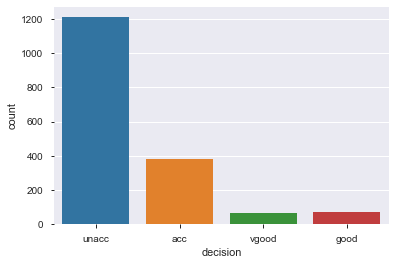

In [4]:
Y = df['decision']
ax = sns.countplot(Y)

### 1.2.2. Numeric Feature & Categorical Feature (X)

In [5]:
X = df.drop('decision', axis=1)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print("There are",X.shape[0], "rows and" , X.shape[1] , "feature(s) in dataset.")
print("-----------------------------------------------------------------------")

print("Number of numeric feature(s):",numeric_features.shape[0])
print("Variable(s) name:",numeric_features)
print("-----------------------------------------------------------------------")

print("Number of categorical feature(s):",categorical_features.shape[0])
print("Variable(s) name:",categorical_features)

There are 1728 rows and 6 feature(s) in dataset.
-----------------------------------------------------------------------
Number of numeric feature(s): 0
Variable(s) name: Index([], dtype='object')
-----------------------------------------------------------------------
Number of categorical feature(s): 6
Variable(s) name: Index(['buying_price', 'maintenance_cost', 'number_of_doors',
       'number_of_persons', 'lug_boot', 'safety'],
      dtype='object')


In [6]:
if numeric_features.shape[0] > 0:
    print(df[numeric_features].describe())
else:
    print("There is no numeric feature, skip this part")

There is no numeric feature, skip this part


In [7]:
if categorical_features.shape[0] > 0:
    print(df[categorical_features].describe())
else:
    print("There is no categorical feature, skip this part")

       buying_price maintenance_cost number_of_doors number_of_persons  \
count          1728             1728            1728              1728   
unique            4                4               4                 3   
top            high             high           5more              more   
freq            432              432             432               576   

       lug_boot safety  
count      1728   1728  
unique        3      3  
top         big   high  
freq        576    576  


# 2. Feature Engineering

Feature engineering is the process of selecting and transforming variables.

## 2.1. Handling Missing Value

if there are missing values, impute missing values before building an estimator. For numeric feature and categorical feature, impute missing value with median and "missing" respectively. In this dataset, there are no missing values. 

In [8]:
nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending=False))
nulls.columns = ['Missing Value Count']
nulls.index.name = 'Feature'
print(nulls)

                   Missing Value Count
Feature                               
decision                             0
safety                               0
lug_boot                             0
number_of_persons                    0
number_of_doors                      0
maintenance_cost                     0
buying_price                         0


## 2.2.  Standardization of Numeric Feature

Standardize features by removing the mean and scaling to unit variance.

## 2.3. OneHot Encoding of Categorical Feature

One-hot encoding can be applied to the integer representation. This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value.

In [9]:
# Define funcation to store encoded column name
def get_feature_names(columnTransformer):

    output_features = []

    for name, pipe, features in columnTransformer.transformers_:
        if name!='remainder':
            for i in pipe:
                trans_features = []
                if hasattr(i,'categories_'):
                    trans_features.extend(i.get_feature_names(features))
                else:
                    trans_features = features
            output_features.extend(trans_features)

    return output_features

In [10]:
# Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')

In [11]:
# Apply preprocessor in feature (X)
preprocessor.fit(X)
# Encoded feature name
encoded_feature_names = get_feature_names(preprocessor)
print(encoded_feature_names)

['buying_price_high', 'buying_price_low', 'buying_price_med', 'buying_price_vhigh', 'maintenance_cost_high', 'maintenance_cost_low', 'maintenance_cost_med', 'maintenance_cost_vhigh', 'number_of_doors_2', 'number_of_doors_3', 'number_of_doors_4', 'number_of_doors_5more', 'number_of_persons_2', 'number_of_persons_4', 'number_of_persons_more', 'lug_boot_big', 'lug_boot_med', 'lug_boot_small', 'safety_high', 'safety_low', 'safety_med']


In [12]:
# Encoded feature value (show first 3 rows)
encoded_feature_data = preprocessor.fit_transform(X).toarray()
print(encoded_feature_data[:3])

[[0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.]]


In [13]:
# Encoded feature dataset
encoded_X_df = pd.DataFrame(data=encoded_feature_data,columns=encoded_feature_names)
encoded_X_df.head()

,buying_price_high,buying_price_low,buying_price_med,buying_price_vhigh,maintenance_cost_high,maintenance_cost_low,maintenance_cost_med,maintenance_cost_vhigh,number_of_doors_2,number_of_doors_3,...,number_of_doors_5more,number_of_persons_2,number_of_persons_4,number_of_persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## 2.4. Feature Selection

Feature selection is the process of selecting a subset of relevant features (variables, predictors) for use in model construction.

we can perform a chi-square test to the samples to retrieve only the 10 best features as follows:

In [14]:
selector = SelectKBest(chi2, k=10)
selector.fit(encoded_X_df, Y)

X_selected = selector.fit_transform(encoded_X_df, Y)
print(X_selected.shape)
print(selector.scores_)

(1728, 10)
[3.65280992e+01 8.68233643e+01 1.54617941e+01 5.04297521e+01
 1.91809401e+01 5.78680441e+01 1.54617941e+01 5.04297521e+01
 6.86669425e+00 2.43173699e-01 1.63745612e+00 1.63745612e+00
 2.46585124e+02 6.95162980e+01 5.52353062e+01 2.06516156e+01
 1.25756857e+00 3.13728412e+01 1.73492625e+02 2.46585124e+02
 5.92446910e+01]


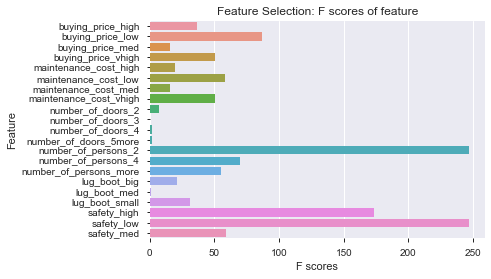

In [15]:
# Feature selection plot
sns.barplot(y=encoded_feature_names,x=selector.scores_)
plt.title('Feature Selection: F scores of feature')
plt.xlabel('F scores')
plt.ylabel('Feature');

In [16]:
selected_feature_index = selector.get_support(indices=True)
print(selected_feature_index)
selected_feature_df = encoded_X_df.iloc[:,selected_feature_index]

selected_feature_name = selected_feature_df.columns
print(selected_feature_name)

selected_feature_df.head()

[ 1  3  5  7 12 13 14 18 19 20]
Index(['buying_price_low', 'buying_price_vhigh', 'maintenance_cost_low',
       'maintenance_cost_vhigh', 'number_of_persons_2', 'number_of_persons_4',
       'number_of_persons_more', 'safety_high', 'safety_low', 'safety_med'],
      dtype='object')


,buying_price_low,buying_price_vhigh,maintenance_cost_low,maintenance_cost_vhigh,number_of_persons_2,number_of_persons_4,number_of_persons_more,safety_high,safety_low,safety_med
0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


# 3. Classification Model Setting

The following setting will be applied in each classification model.

## 3.1. Model Validation

To aviod overfitting or underfitting problem, 5-folds cross-validation has applied.

The data set is split into 5 folds. In the first iteration, the first fold is used to test the model and the rest are used to train the model. This process is repeated until each fold of the 5 folds have been used as the testing set.

In [17]:
k_fold = model_selection.KFold(n_splits=5, random_state=123)

## 3.2. Model Optimization

Turning model parameters with grid search.

## 3.3. Model Evaluation

The model selection criteria is balanced F-score in testing data.

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. 

Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). It can solve imbanlance dataset problem.

## 3.4. Speed up Training Time

Multiprocessing module to parallelize execution onto several Python processes by passing n_jobs = -2 as argument.

n_jobs = -2, all CPUs but one are used.

## 4. Support Vector Machine (SVM)

SVM find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

There are 4 common kernel function, include linear, polynomial, rbf and sigmoid. 

In general, the RBF kernel is a reasonable first choice. This kernel nonlinearly maps samples into a higher dimensional space so it, unlike the linear kernel, can handle the
case when the relation between class labels and attributes is nonlinear.

https://scikit-learn.org/stable/modules/svm.html#svm-kernels

## 4.1  Turning Model Parameters with Grid Search

In SVM model, there are 2 parameters.

Cost: which controls training errors and margins. Small cost creates a large margin (a soft margin) and allows more misclassifications, and vice versa.

Gamma: how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’.

In [18]:
Cost = [2**i for i in range(-5,15)]
Gamma = [2**i for i in range(-15,3)]

print("Cost:",Cost)
print("Gamma:",Gamma)

Cost: [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
Gamma: [3.0517578125e-05, 6.103515625e-05, 0.0001220703125, 0.000244140625, 0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4]


if model exist, reload model. Otherwise, create new model and save it.

In [19]:
# Check if object exist
try:
    load('SVM.joblib') 
except FileNotFoundError:
    print("The model is not exist, now create & save model")
    
    from sklearn import svm
    
    svm_grid = {'C': Cost, 'gamma': Gamma}
    svm_model = GridSearchCV(svm.SVC(max_iter=10000,kernel='rbf'), 
                             svm_grid, cv=k_fold, scoring='f1_weighted',
                             return_train_score=True, n_jobs=-2)
    svm_model.fit(selected_feature_df,Y)
    # Save model in current folder 
    dump(svm_model, 'SVM.joblib')
else:
    svm_model = load('SVM.joblib')
    print("Reload existing model")

The model is not exist, now create & save model


C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## 4.2. Model Summary

The following 3D scatter plot shows the balanced F-score of cross validation result.

In [20]:
print('Balanced F-score in:')
print('Test Data:',svm_model.cv_results_['mean_test_score'][svm_model.best_index_])
print('Train Data:',svm_model.cv_results_['mean_train_score'][svm_model.best_index_])
print('------------------------------------------------------------')
print('SVM optimal parameter:')
print('Cost:',svm_model.cv_results_['param_C'][svm_model.best_index_])
print('Gamma:',svm_model.cv_results_['param_gamma'][svm_model.best_index_])

Balanced F-score in:
Test Data: 0.7503222280098436
Train Data: 0.8424944414886589
------------------------------------------------------------
SVM optimal parameter:
Cost: 0.5
Gamma: 0.125


## 4.3. Model Evaluation
Confusion matrix shows classification result.

SVM model accuarcy: 84.78 %


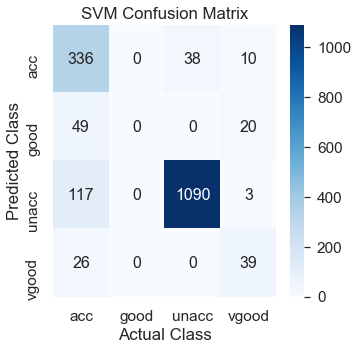

In [21]:
pred = svm_model.predict(encoded_X_df[selected_feature_name])
cm = confusion_matrix(Y, pred)

columns = np.unique(Y)

df_cm = pd.DataFrame(cm, index=columns, columns=columns)

plt.figure(figsize=(5,5))
sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, fmt='g',cmap='Blues',annot_kws={"size": 16}) # font size
ax.set(xlabel='Actual Class', ylabel='Predicted Class')
ax.set_title('SVM Confusion Matrix')

print("SVM model accuarcy:",round(sum(Y == pred)/Y.count(),4)*100,"%")

## 5. Random Forest

Random forests are an ensemble learning method for classification that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes of the individual trees.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## 5.1  Turning Model Parameters with Grid Search

There are 6 parameters in random forest model.

n_estimators: number of trees in random forest.

max_features: number of features to consider when looking for the best split.

max_depth: maximum depth of the decision tree.

min_samples_split: minimum number of samples required to split an internal node.

min_samples_leaf: minimum number of samples required to be at a leaf node.

bootstrap: repeatedly sample data with replacement from the original training set in order to produce multiple separate training sets.

In [22]:
n_estimators = [2**i for i in range(1,6)]
max_features = ['auto', 'sqrt']
max_depth = [2**i for i in range(1,5)]
min_samples_split = [2**i for i in range(1,5)]
min_samples_leaf = [2**i for i in range(1,5)]
bootstrap = [True, False]

print('n_estimators:',n_estimators)
print('max_features:',max_features)
print('max_depth:',max_depth)
print('min_samples_split:',min_samples_split)
print('min_samples_leaf:',min_samples_leaf)
print('bootstrap:',bootstrap)

n_estimators: [2, 4, 8, 16, 32]
max_features: ['auto', 'sqrt']
max_depth: [2, 4, 8, 16]
min_samples_split: [2, 4, 8, 16]
min_samples_leaf: [2, 4, 8, 16]
bootstrap: [True, False]


In [23]:
# Check if object exist
try:
    load('RF.joblib') 
except FileNotFoundError:
    print("The model is not exist, now create & save model")
    
    from sklearn.ensemble import RandomForestClassifier
    
    rf_grid  = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
    
    rf_model = GridSearchCV(RandomForestClassifier(), 
                             rf_grid, cv=k_fold, scoring='f1_weighted',
                             return_train_score=True, n_jobs=-2)
    
    rf_model.fit(selected_feature_df,Y)
    # Save model in current folder 
    dump(rf_model, 'RF.joblib')
else:
    rf_model = load('RF.joblib')
    print("Reload existing model")

The model is not exist, now create & save model


C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## 4.2. Model Summary

In [24]:
print('Balanced F-score in:')
print('Test Data:',rf_model.cv_results_['mean_test_score'][rf_model.best_index_])
print('Train Data:',rf_model.cv_results_['mean_train_score'][rf_model.best_index_])
print('------------------------------------------------------------')
print('Parameters:')
print('n_estimators:',rf_model.cv_results_['param_n_estimators'][rf_model.best_index_])
print('max_features:',rf_model.cv_results_['param_max_features'][rf_model.best_index_])
print('max_depth:',rf_model.cv_results_['param_max_depth'][rf_model.best_index_])
print('min_samples_split:',rf_model.cv_results_['param_min_samples_split'][rf_model.best_index_])
print('min_samples_leaf:',rf_model.cv_results_['param_min_samples_leaf'][rf_model.best_index_])
print('bootstrap:',rf_model.cv_results_['param_bootstrap'][rf_model.best_index_])

Balanced F-score in:
Test Data: 0.7755762205553774
Train Data: 0.8487331726458655
------------------------------------------------------------
Parameters:
n_estimators: 4
max_features: auto
max_depth: 8
min_samples_split: 8
min_samples_leaf: 8
bootstrap: True


## 5.3. Classification Result
Confusion matrix shows classification result.

Random Forest model accuarcy: 84.95 %


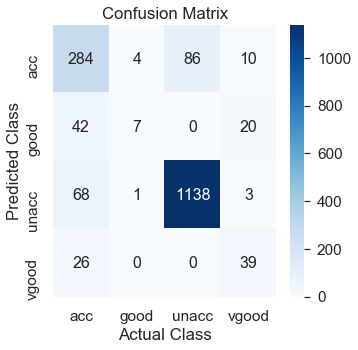

In [25]:
pred = rf_model.predict(selected_feature_df)
cm = confusion_matrix(Y, pred)

columns = np.unique(Y)

df_cm = pd.DataFrame(cm, index=columns, columns=columns)

plt.figure(figsize=(5,5))
sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, fmt='g',cmap='Blues',annot_kws={"size": 16}) # font size
ax.set(xlabel='Actual Class', ylabel='Predicted Class')

ax.set_title('Confusion Matrix')

print("Random Forest model accuarcy:",round(sum(Y == rf_model.predict(selected_feature_df))/Y.count(),4)*100,"%")

## 5.4. Feature Important in Random Forest

The 3 most important factors affecting car acceptability are safety, number of seats and price.

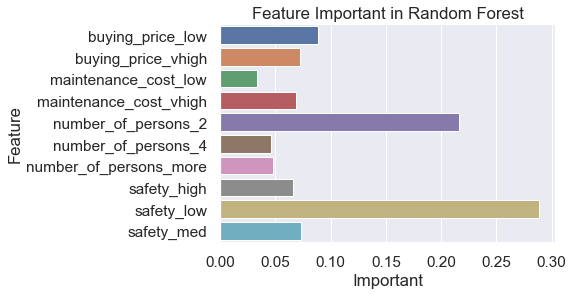

In [31]:
sns.barplot(y=selected_feature_df.columns,x=rf_model.best_estimator_.feature_importances_)

plt.title('Feature Important in Random Forest')
plt.xlabel('Important')
plt.ylabel('Feature');

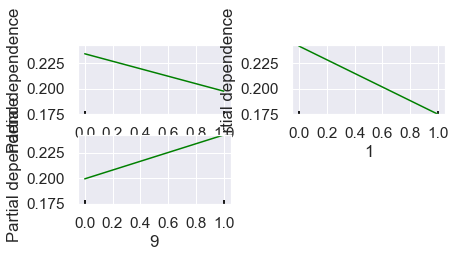

In [49]:
from sklearn.inspection import plot_partial_dependence

plot_partial_dependence(rf_model,
                        X=selected_feature_df,
                        features=[0,1,9],
                        target='vgood',
                        n_cols=2) 